### <span style="color:rgb(234,81,96)">Optimisation pour l'apprentissage automatique</span>

### <span style="color:rgb(234,81,96)">Master 2 IASD Apprentissage 2025-2026</span>


# <span style="color:rgb(234,81,96)">Notebook d'illustration - Méthodes de gradient</span>

Dans ce notebook, on s'intéresse aux algorithmes centraux en apprentissage, à savoir les méthodes de gradient stochastique. On illustre les propriétés basiques de ces méthodes sur des problèmes de régression linéaire et logistique.

Les sources de ce notebook sont disponibles [ici](https://www.lamsade.dauphine.fr/~croyer/ensdocs/OAA/LabOAA-MethodesGradient.zip).

Pour tout commentaire concernant ce notebook, merci d'envoyer un mail à  **clement.royer@lamsade.dauphine.fr**.

In [1]:
# Import des bibliotheques et fonctions utiles
###############################################

# Affichage
%matplotlib inline
import matplotlib.pyplot as plt

from math import sqrt # Racine carrée
from math import ceil # Partie entière supérieure
from math import log # Logarithme

# NumPy - Structures vectorielles et matricielles
import numpy as np # Bibliothèque NumPy
from numpy.random import multivariate_normal, randn, uniform # Distributions de probabilités

# SciPy - Calculs mathématiques efficaces
from scipy.linalg import toeplitz # Matrices de Toeplitz
from scipy.linalg import norm # Norm euclidienne (correspondant au produit scalaire)
from scipy.linalg import svdvals # Décomposition en valeurs singulières
from scipy.optimize import fmin_l_bfgs_b # Méthode d'optimisation efficace

# <span style="color:rgb(234,81,96)">Partie 1 - Génération des données et somme finie</span>



## <span style="color:rgb(234,81,96)">1.1 - Génération des données</span>

Comme lors des séances de cours, on considère un jeu de données $\{(\mathbf{x}_i,y_i)\}_{i=1,\dots,n}$ à $n$ éléments. Dans les exemples qui nous intéressent, on aura $\mathbf{x}_i \in \mathbb{R}^d$ et $y_i \in \mathbb{R}$ mis sous la forme

- d'une matrice de caractéristiques (features) $\mathbf{X} \in \mathbb{R}^{n \times d}$;
- et d'un vecteur de labels $\mathbf{y} \in \mathbb{R}^n$. 

On cherchera à apprendre un modèle $h$ paramétré par un vecteur $\mathbf{w}$ qui explique les données au sens d'une fonction de perte $\ell$. Cela se formule via le problème suivant :
$$
    \mathrm{minimiser}_{\mathbf{w} \in \mathbb{R}^d} f(\mathbf{w}) = \frac{1}{n} \sum_{i=1}^n f_i(\mathbf{w}), \qquad f_i(\mathbf{w}) = \ell(h(\mathbf{x}_i;\mathbf{w}),y_i) + \frac{\lambda}{2}\|\mathbf{w}\|^2.
$$
où $\lambda \ge 0$ est un paramètre de régularisation, dont le rôle sera décrit dans les séances futures.

In [2]:
# Génération des données
# Ce code est issu d'un générateur proposé par A. Gramfort (INRIA).
def simu_lin(wtruth, n, std=1., corr=0.5):
    
    """
    Modèle linéaire avec bruit additif
    
    Entrées
    ----------
        w : Coefficients du modèle
    
        n : Nombre d'échantillons
    
        std : Ecart-type
        
        corr : Facteur de corrélation
        
    Sorties
    ----------
    
        X,y: Matrice d'attributs et vecteur de labels
    """    
    d = wtruth.shape[0]
    cov = toeplitz(corr ** np.arange(0, d))
    X = multivariate_normal(np.zeros(d), cov, size=n)
    noise = std * randn(n)
    y = X.dot(wtruth) + noise
    return X, y

Les données sont donc produites par un modèle linéaire corrompu par un bruit gaussien, un cadre dans lequel on sait que la descente de gradient stochastique donnera de bons résultats. 
On donne ci-dessous les propriétés des formulations de régression linéaire et logistique.

### <span style="color:rgb(234,81,96)">Régression linéaire</span>

Dans le cadre de la régression linéaire, on considère une fonction de perte aux moindres carrés et le problème
$$
    \mathrm{minimiser}_{\mathbf{w} \in \mathbb{R}^d} f(\mathbf{w}) 
    := \frac{1}{2 n} \|\mathbf{X} \mathbf{w} - \mathbf{y}\|^2 + \frac{\lambda}{2}\|\mathbf{w}\|^2.
$$ 

- La fonction $f$ est quadratique, donc $\mathcal{C}^1$. Son gradient est donné en tout $\mathbf{w} \in \mathbb{R}^d$ par
$$
    \nabla f(\mathbf{x}) = \frac{1}{n}\mathbf{A}^T (\mathbf{A} \mathbf{x} - \mathbf{y}) + \lambda \mathbf{x}.
$$
- La fonction $f$ est même $\mathcal{C}^{1,1}_L$ avec $L = \frac{\|\mathbf{X}^T \mathbf{X}\|}{n}+\lambda$. 
- La fonction $f$ est convexe, et même $(\sigma_{\min}(\mathbf{X})^2+\lambda)$-fortement convexe lorsque $\sigma_{\min}(\mathbf{X})^2+\lambda>0$, où $\sigma_{\min}(\mathbf{X})$ désigne la plus petite valeur singulière de $\mathbf{X}$.

### <span style="color:rgb(234,81,96)">Régression logistique</span>

En *régression logistique*, on considère toujours un modèle linéaire, mais pour des besoins de classification binaire (avec $y_i \in \{-1,1\}$). Le problème correspondant est donné par
$$
    \mathrm{minimiser}_{\mathbf{w} \in \mathbb{R}^d} f(\mathbf{w}) 
    := \frac{1}{n} \sum_{i=1}^n f_i(\mathbf{w}), \qquad 
    f_i(\mathbf{w})=\log(1+\exp(-y_i \mathbf{x}_i^T \mathbf{w}))+\frac{\lambda}{2}\|\mathbf{w}\|^2.
$$

- La fonction $f$ est de classe $\mathcal{C}^{1}$. Pour tout $\mathbf{w} \in \mathbb{R}^d$, o a
$$
\nabla f(\mathbf{w}) = \frac{1}{n}\sum_{i=1}^n  -\frac{y_i}{1 + \exp(y_i \mathbf{x}_i^T \mathbf{w})} \mathbf{x}_i + \lambda \mathbf{x}.
$$
- La fonction $f$ est de classe $\mathcal{C}^{1,1}_L$ avec $L =\frac{\|\mathbf{A}^T \mathbf{A}\|}{4n}+\lambda$.
- La fonction $f$ est convexe et même $\lambda$-fortement convexe lorsque $\lambda>0$.

## <span style="color:rgb(234,81,96)">1.2 Classe Python et instances</span>

In [3]:
# Classe Python pour les problèmes de régression
class RegPb(object):
    '''
        Classe de problèmes de régression avec modèles linéaires
        
        Attributs:
            X: Matrice de données (attributs)
            y: Vecteur de données (labels)
            n,d: Dimensions de X
            loss: Fonction de perte choisie
                'l2': Perte aux moindres carrés
                'logit': Perte logistique
            lbda: Paramètre de régularisation
    '''
   
    # Initialisation
    def __init__(self, X, y,lbda=0,loss='l2'):
        self.X = X
        self.y = y
        self.n, self.d = X.shape
        self.loss = loss
        self.lbda = lbda
        
    
    # Fonction objectif
    def fun(self, w):
        if self.loss=='l2':
            return norm(self.X.dot(w) - self.y) ** 2 / (2. * self.n) + self.lbda * norm(w) ** 2 / 2.
        elif self.loss=='logit':
            yXw = self.y * self.X.dot(w)
            return np.mean(np.log(1. + np.exp(-yXw))) + self.lbda * norm(w) ** 2 / 2.
    
    # Fonction objectif pour un échantillon
    def f_i(self, i, w):
        if self.loss=='l2':
            return norm(self.X[i].dot(w) - self.y[i]) ** 2 / (2.) + self.lbda * norm(w) ** 2 / 2.
        elif self.loss=='logit':
            yXwi = self.y[i] * np.dot(self.X[i], w)
            return np.log(1. + np.exp(- yXwi)) + self.lbda * norm(w) ** 2 / 2.
    
    # Gradient
    def grad(self, w):
        if self.loss=='l2':
            return self.X.T.dot(self.X.dot(w) - self.y) / self.n + self.lbda * w
        elif self.loss=='logit':
            yXw = self.y * self.X.dot(w)
            aux = 1. / (1. + np.exp(yXw))
            return - (self.X.T).dot(self.y * aux) / self.n + self.lbda * w
    
    # Gradient pour un point du jeu de données
    def grad_i(self,i,w):
        x_i = self.X[i]
        if self.loss=='l2':
            return (x_i.dot(w) - self.y[i]) * x_i + self.lbda*w
        elif self.loss=='logit':
            grad = - x_i * self.y[i] / (1. + np.exp(self.y[i]* x_i.dot(w)))
            grad += self.lbda * w
            return grad

    # Constante de Lipschitz pour le gradient
    def lipgrad(self):
        if self.loss=='l2':
            L = norm(self.X, ord=2) ** 2 / self.n + self.lbda
        elif self.loss=='logit':
            L = norm(self.X, ord=2) ** 2 / (4. * self.n) + self.lbda
        return L
    
    # Constante de convexité ''forte'' (potentiellement 0 si self.lbda=0)
    def cvxval(self):
        if self.loss=='l2':
            s = svdvals(self.X)
            mu = min(s)**2 / self.n 
            return mu + self.lbda
        elif self.loss=='logit':
            return self.lbda

On génére une instance de régression linéaire et une de régression logistique, avec à chaque fois $$d=50 \ll n=1000.$$

In [5]:
# Génération de deux instances de taille modéréed = 50
n = 1000
d = 50
idx = np.arange(d)
lbda = 1. / n ** (0.5)

# On fixe le générateur de nombres aléatoires
np.random.seed(0)

# Coefficients de la solution
w_model_truth = (-1)**idx * np.exp(-idx / 10.)

Xlin, ylin = simu_lin(w_model_truth, n, std=1., corr=0.1)
Xlog, ylog = simu_lin(w_model_truth, n, std=1., corr=0.7)
ylog = np.sign(ylog) # On prend le signe pour la classification binaire

pblinreg = RegPb(Xlin, ylin,lbda,loss='l2')
pblogreg = RegPb(Xlog, ylog,lbda,loss='logit')

Comme les dimensions du problème sont relativement modestes ($d=50,n=1000$), on peut appliquer une technique plus puissante que la descente de gradient pour calculer une valeur optimale et une solution approchées. *Dans un contexte de données massives, voire d'optimisation sur un très grand nombre de paramètres, cette méthode ne pourrait pas être utilisée car trop coûteuse.*

In [6]:
# Utiliser L-BFGS-B pour résoudre les problèmes

w_init = np.zeros(d)

# Cas de la régression linéaire
w_min_lin, f_min_lin, _ = fmin_l_bfgs_b(pblinreg.fun, w_init, pblinreg.grad, args=(), pgtol=1e-30, factr =1e-30)
print("Regression lineaire:")
print("\t Valeur optimale numerique:",f_min_lin)
print("\t Norme du gradient en la solution numerique:",norm(pblinreg.grad(w_min_lin)))

# Cas de la régression logistique
w_min_log, f_min_log, _ = fmin_l_bfgs_b(pblogreg.fun, w_init, pblogreg.grad, args=(), pgtol=1e-30, factr =1e-30)
print("Regression logistique:")
print("\t Valeur optimale numerique:",f_min_log)
print("\t Norme du gradient en la solution numerique:",norm(pblogreg.grad(w_min_log)))

Regression lineaire:
	 Valeur optimale numerique: 0.5609973667736609
	 Norme du gradient en la solution numerique: 1.9229325715619484e-09
Regression logistique:
	 Valeur optimale numerique: 0.5621593875942844
	 Norme du gradient en la solution numerique: 1.3448915657323013e-09


Si $f^*$ et $\mathbf{w}^*$ désignent les valeurs obtenues via L-BFGS, et $\{\mathbf{w}_k\}$ une suite d'itérés obtenus par un algorithme, on s'intéressera au comportement des quantités
$f(\mathbf{w}_k)-f^*$ et $\|\mathbf{w}_k -\mathbf{w}^*\|$.

# <span style="color:rgb(234,81,96)">Partie 2 - Méthode de gradient stochastique</span>

Dans cette partie, on illustre le comportement de l'algorithme du gradient stochastique dans sa version de base, et les différents hyperparamètres sur lesquels on peut jouer lorsque l'on implémente cette méthode.

## <span style="color:rgb(234,81,96)"> 2.1 Algorithme de base</span>

Une itération de gradient stochastique s'écrit
$$
    \mathbf{w}_{k+1} = \mathbf{w}_k - \alpha_k \nabla f_{i_k}(\mathbf{w}_k),
$$
où $i_k$ est tiré aléatoirement dans $\{1,\dots,n\}$. Dans ce notebook, on tirera $i_k$ de manière uniforme, de sorte que chaque valeur entre $1$ et $n$ possède une probabilité $\tfrac{1}{n}$ d'être tirée.

Une version plus générale de l'algorithme, dite par fournées (*batch*), est décrite par l'itération
$$
    \mathbf{w}_{k+1} = \mathbf{w}_k - \frac{\alpha_k}{|\mathcal{S}_k|} \sum_{i \in \mathcal{S}_k} \nabla f_i(\mathbf{w}_k)
$$
où $\mathcal{S}_k$ est un ensemble d'indices tirés aléatoirement dans $\{1,\dots,n\}$. Dans ce notebook, on considèrera des tirages avec remise et sans remise, le dernier cas étant utilisé pour obtenir la descente de gradient (tirage de $n$ indices sans remise). Pour simplifier les choses, on prendra une taille de fournée constante. 

#### <span style="color:rgb(234,81,96)">Coût d'une itération</span>

Une itération d'une méthode par fournées utilisant une taille de fournée $n_b$ requiert $n_b$ accès à un point du jeu de données (où deux accès à un même point comptent pour deux).

#### <span style="color:rgb(234,81,96)">Epoques et comparaison d'algorithmes</span>

Une époque est une unité de coût représentant $n$ accès aux points d'un jeu de données à $n$ éléments (équivalent à une passe sur le jeu de données global). Plutôt que de comparer des algorithmes pour un budget d'itérations fixé, on les compare pour un budget d'époques fixé. Cela permet d'étudier l'intérêt de faire plus d'itérations avec le même budget. Pour une méthode utilisant une taille de fournée $n_b$, une époque permettra ainsi d'effectuer $\tfrac{n}{n_b}$ itérations.


Le code ci-dessous implémente l'algorithme du gradient stochastique par fournées avec deux choix possibles pour la taille de pas :
 - $\alpha_k=\tfrac{1}{L}$ (constante);
 - $\alpha_k=\frac{\alpha_0}{(k+1)^t}$, avec $\alpha_0$ et $t>0$ (décroissante).


*Note :* La fonction ``np.random.choice(n,m,replace=True)`` tire $m$ valeurs uniformément au hasard dans $\{1,\dots,n\}$ avec remise (remplacer `True` par `False` pour tirer sans remise).

In [7]:
# Implémentation du gradient stochastique
def stoch_grad(w0,problem,wtarget,stepchoice=0,step0=1, n_iter=1000,nb=1,with_replace=False,verbose=False): 
    """
        Algorithme du gradient stochastique
        
        Entrées:
            w0: Point initial
            problem: Instance à minimiser
                problem.fun(x) Fonction objectif
                problem.grad_i() Gradient d'une fonction f_i de la somme finie
                problem.lipgrad() Constante de Lipschitz pour le gradient
            wopt: Minimum cible pour l'optimisation
            stepchoice: Choix de taille de pas
                0: Constante proportionnelle à 1/L (L constante de Lipschitz pour le gradient)
                a>0: Décroissante, set to 1/((k+1)**a)
            step0: Taille de pas initiale
            n_iter: Maximum d'itérations
            nb: Taille de fournées
            with_replace: Indicateur d'un tirage aléatoire des indices avec ou sans remise
            verbose: Affichage d'informations à chaque itération
            
        Sorties:
            w_output: Dernier itéré de la méthode
            objvals: Historique de valeurs de fonctions (tableau Numpy de taille n_iter+1)
            distits: Historique de distances à l'optimum cible (tableau Numpy de taille n_iter+1)
    """
    ############
    # Initialisation
    objvals = []
    normits = []
    
    # Constante de Lipschitz
    L = problem.lipgrad()
    
    # Taille du jeu de données
    n = problem.n
    
    # Point initial 
    w = w0.copy()
    nw = norm(w)

    # Compteur d'itération
    k=0
    
    # Premires calculs
    obj = problem.fun(w) 
    objvals.append(obj);
    nmin = norm(w-wtarget)
    normits.append(nmin)
    
    if verbose:
        # Affichage optionnel 
        print("Gradient Stochastique, fournée=",nb,"/",n)
        print(' | '.join([name.center(8) for name in ["iter", "fval", "normit"]]))
        print(' | '.join([("%d" % k).rjust(8),("%.2e" % obj).rjust(8),("%.2e" % nmin).rjust(8)]))
    
    ################
    # Boucle principale
    while (k < n_iter and nw < 10**100):
        
        ########
        
        # Tirage du ou des indices
        ik = np.random.choice(n,nb,replace=with_replace)
        # Calcul du ou des gradient stochastique(s)
        sg = np.zeros(d)
        for j in range(nb):
            gi = problem.grad_i(ik[j],w)
            sg = sg + gi
        sg = (1/nb)*sg
        
        #######
            
        if stepchoice==0:
            w[:] = w - (step0/L) * sg
        elif stepchoice>0:
            sk = float(step0/((k+1)**stepchoice))
            w[:] = w - sk * sg
        
        nw = norm(w) #Calcul de norme d'itéré pour éviter de trop diverger

        obj = problem.fun(w)
        nmin = norm(w-wtarget)
        
        k += 1
        # Calcul des quantités d'intérêt à la fin de chaque époque
        if (k*nb) % n == 0:
            objvals.append(obj)
            normits.append(nmin)
            if verbose:
                print(' | '.join([("%d" % k).rjust(8),("%.2e" % obj).rjust(8),("%.2e" % nmin).rjust(8)]))       
    
    # Fin boucle principale
    #################
    
    # Affichage final
    if (k*nb) % n > 0:
        objvals.append(obj)
        normits.append(nmin)
        if verbose:
            print(' | '.join([("%d" % k).rjust(8),("%.2e" % obj).rjust(8),("%.2e" % nmin).rjust(8)]))              
    
    # Solution
    w_output = w.copy()
    
    return w_output, np.array(objvals), np.array(normits)

## <span style="color:rgb(234,81,96)"> 2.2 Gradient stochastique VS Descente de gradient</span>

Le script ci-dessous compare le gradient stochastique avec la descente de gradient pour un budget de 60 époques, et avec deux choix de taille de pas : $\alpha_k = \tfrac{1}{L}$ et $\alpha_k = \tfrac{0.2}{\sqrt{k+1}}$.

In [8]:
# Comparaison gradient descent/stochastic gradient
# Note: Le nombre d'itérations de chaque méthode est proportionnel au coût d'une itération
nb_epochs = 60
n = pblinreg.n
nbset = 1
w0 = np.zeros(d)

# Run a - Descente de gradient, taille de pas constante
w_a, obj_a, nits_a = stoch_grad(w0,pblogreg,w_min_log,stepchoice=0,step0=1, n_iter=nb_epochs,nb=n)

# Run b - Gradient stochastique, taille de pas constante
# Cette instance peut diverger (d'où l'utilisation de norm(w) dans l'algorithme)
w_b, obj_b, nits_b = stoch_grad(w0,pblogreg,w_min_log,stepchoice=0,step0=1, n_iter=int(nb_epochs*n/nbset),nb=1)

# Run c - Descente de gradient, taille de pas décroissante
w_c, obj_c, nits_c = stoch_grad(w0,pblogreg,w_min_log,stepchoice=0.5,step0=0.2, n_iter=nb_epochs,nb=n)
# Run d - Gradient stochastique, taille de pas décroissante
w_d, obj_d, nits_d = stoch_grad(w0,pblogreg,w_min_log,stepchoice=0.5,step0=0.2, n_iter=nb_epochs*n,nb=1)

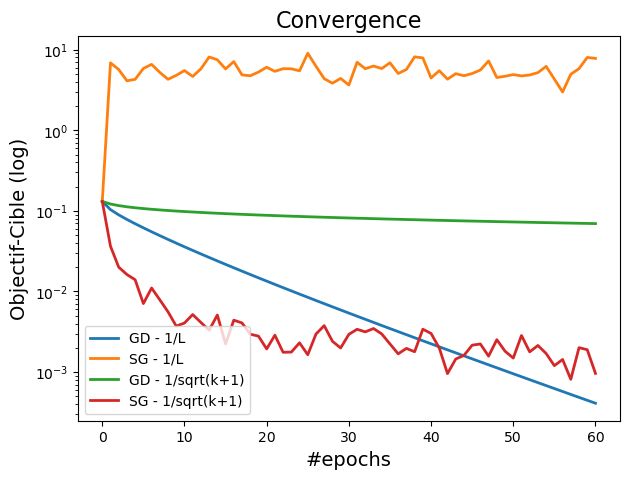

In [9]:
# Affichage des différentes méthodes
# Abscisse : Nombre d'époques
# Ordonnée : Ecart à l'optimum numérique

plt.figure(figsize=(7, 5))
plt.semilogy(obj_a-f_min_log, label="GD - 1/L", lw=2)
plt.semilogy(obj_b-f_min_log, label="SG - 1/L", lw=2)
plt.semilogy(obj_c-f_min_log, label="GD - 1/sqrt(k+1)", lw=2)
plt.semilogy(obj_d-f_min_log, label="SG - 1/sqrt(k+1)", lw=2)
plt.title("Convergence", fontsize=16)
plt.xlabel("#epochs", fontsize=14)
plt.ylabel("Objectif-Cible (log)", fontsize=14)
plt.legend()

#### <span style="color:rgb(234,81,96)">Commentaires</span>

- L'algorithme du gradient stochastique n'est pas une méthode de descente, et est aléatoire. Par conséquent, il est possible qu'une itération augmente la valeur de l'objectif, et c'est ce que l'on observe ici.

- La courbe rouge (GS à pas décroissant) correspond à un comportement classique du gradient stochastique : on observe une décroissance forte de $f$ durant les premières époques, suivie par une phase "oscillatoire" durant laquelle la méthode ne semble plus améliorer la valeur de fonction en moyenne. La convergence de la courbe de descente de gradient correspondante, bien que plus lente, finit par être meilleure que celle du gradient stochastique, ce qui confirme là aussi la théorie.

- La courbe orange (GS avec pas constant) présente aussi des oscillations, mais elle débute par une forte croissantce de l'objectif. Cela ne contredit pas le fait que la méthode diminue les valeurs de fonction en moyenne, mais il s'agit là d'un exemple de comportement éloigné de la moyenne, et valable *pour une réalisation de la méthode*.

## <span style="color:rgb(234,81,96)"> 2.3 Gradient stochastique et taille de pas</span>

L'implémentation d'une méthode de gradient stochastique requiert souvent de calibrer la taille de pas (appelée aussi *learning rate*). On compare ci-dessous plusieurs valeurs constantes proportionnelles à $\frac{1}{L}$, dont on sait qu'il s'agit d'un bon choix de pas pour la descente de gradient.

In [10]:
# Comparaison de tailles de pas constantes

nb_epochs = 60
n = pblinreg.n
nbset = 1
w0 = np.zeros(d)

valsstep0 = [1,0.1,0.01,0.001,0.0001]
nvals = len(valsstep0)

objs = np.zeros((nb_epochs+1,nvals))

for val in range(nvals):
    _, objs[:,val], _ = stoch_grad(w0,pblogreg,w_min_log,stepchoice=0,step0=valsstep0[val], n_iter=int(nb_epochs*n/nbset),nb=1)


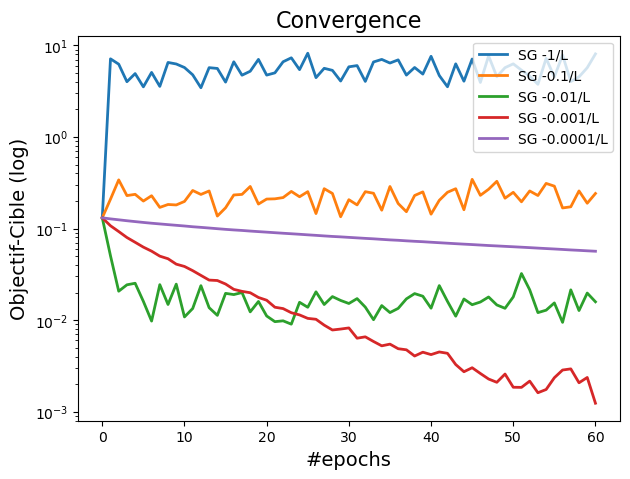

In [11]:
# Affichage des résultats
plt.figure(figsize=(7, 5))
plt.set_cmap("RdPu")
for val in range(nvals):
    plt.semilogy(objs[:,val]-f_min_log, label="SG -"+str(valsstep0[val])+"/L", lw=2)
plt.title("Convergence", fontsize=16)
plt.xlabel("#epochs", fontsize=14)
plt.ylabel("Objectif-Cible (log)", fontsize=14)
plt.legend(loc=1)

On compare aussi des tailles de pas décroissantes. Pour $\alpha_0>0$, on considère (arbitrairement) $\tfrac{\alpha_0}{\sqrt{k+1}}$, $\tfrac{\alpha_0}{k+1}$, $\tfrac{\alpha_0}{(k+1)^{1/4}}$, $\tfrac{\alpha_0}{(k+1)^{2/3}}$.

In [12]:
# Comparaison de tailles de pas décroissantes

nb_epochs = 60
n = pblinreg.n
nbset = 1
w0 = np.zeros(d)

decstep = [1,2/3,1/2,1/4,0]
nvals = len(decstep)

objs = np.zeros((nb_epochs+1,nvals))

for val in range(nvals):
    _, objs[:,val], _ = stoch_grad(w0,pblogreg,w_min_log,stepchoice=decstep[val],step0=0.2, n_iter=int(nb_epochs*n/nbset),nb=1)

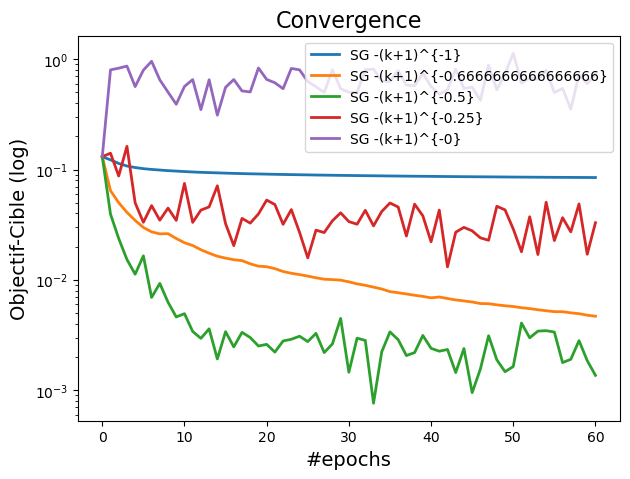

In [13]:
# Affichage
plt.figure(figsize=(7, 5))
plt.set_cmap("RdPu")
for val in range(nvals):
    plt.semilogy(objs[:,val]-f_min_log, label="SG -(k+1)^{-"+str(decstep[val])+"}", lw=2)
plt.title("Convergence", fontsize=16)
plt.xlabel("#epochs", fontsize=14)
plt.ylabel("Objectif-Cible (log)", fontsize=14)
plt.legend(loc=1)

#### <span style="color:rgb(234,81,96)">Commentaires</span>

- **Longueur de pas constante :** On voit qu'une valeur de longueur de pas trop grande peut conduire la méthode à converger loin de la valeur optimale. A contrario, utiliser une longueur de pas trop petite conduit à une convergence très lente, qui n'aboutit pas avec le budget d'époques fixé (comme dans le cas $\tfrac{0.0001}{L}$). Dans tous les cas, on s'attend à ce que la phase de convergence soit suivie d'une phase oscillatoire, ce que l'on observe pour les autres longueurs de pas. Par ailleurs, les courbes rouge et verte (correspondant respectivement aux choix $\tfrac{0.01}{L}$ et $\tfrac{0.001}{L}$) illustrent les avantages et inconvénients d'une petite longueur de pas (convergence lente mais vers une valeur proche plus proche du minimum) et d'une grande longueur de pas (convergence rapide mais potentiellement vers une valeur élevée de l'objectif). 

- **Longueur de pas décroissante :** La plupart des observations faites pour les longueurs de pas constantes s'appliquent ici. Sur cette exécution (et ce problème), le choix $\alpha_k = \tfrac{1}{(k+1)^{1/2}}$ semble être le meilleur globalement. Pour un plus grand nombre d'époques, on pourrait cependant s'attendre à ce que la courbe orange ($\alpha_k = \tfrac{1}{(k+1)^{2/3}}$) obtienne une meilleure valeur que la courbe verte, pour laquelle on est déjà dans un régime d'oscillations après 60 époques.

## <span style="color:rgb(234,81,96)"> 2.4 Choix de la taille de fournée</span>

On compare ci-dessous plusieurs versions de la méthode du gradient stochastique par fournées, en utilisant à chaque fois une taille de fournée (*batch size*) constante (que l'on notera $n_b$ dans la suite). On tirera toujours la fournée sans remise et on prendra $n_b \in \left\{1,\tfrac{n}{100},\tfrac{n}{10},\tfrac{n}{2},n \right\}$ pour considérer le gradient stochastique ($n_b=1$) et la descente de gradient ($n_b=n$).

In [18]:
# Comparaison de tailles de fournées

nb_epochs = 100
n = pblogreg.n
w0 = np.zeros(d)

replace_batch=False

# Gradient stochastique (fournées de taille 1)
w_a, obj_a, nits_a = stoch_grad(w0,pblinreg,w_min_lin,stepchoice=0.5,step0=0.2, n_iter=nb_epochs*n,nb=1)
# Gradient stochastique par fournées de taille n/100
nbset=int(n/100)
w_b, obj_b, nits_b = stoch_grad(w0,pblinreg,w_min_lin,stepchoice=0.5,step0=0.2, n_iter=int(nb_epochs*n/nbset),nb=nbset,with_replace=replace_batch)
# Gradient stochastique par fournées de taille n/10
nbset=int(n/10)
w_c, obj_c, nits_c = stoch_grad(w0,pblinreg,w_min_lin,stepchoice=0.5,step0=0.2, n_iter=int(nb_epochs*n/nbset),nb=nbset,with_replace=replace_batch)
# Gradient stochastique par fournées de taille n/2
nbset=int(n/2)
w_d, obj_d, nits_d = stoch_grad(w0,pblinreg,w_min_lin,stepchoice=0.5,step0=0.2, n_iter=int(nb_epochs*n/nbset),nb=nbset,with_replace=replace_batch)

# Descente de gradient (fournées de taille n)
w_f, obj_f, nits_f = stoch_grad(w0,pblinreg,w_min_lin,stepchoice=0.5,step0=0.2, n_iter=int(nb_epochs),nb=n)

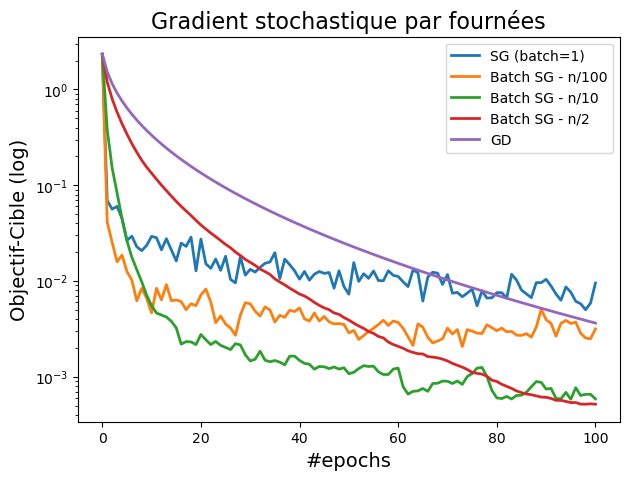

In [19]:
# Résultats

# En termes de fonction objectif (log)
plt.figure(figsize=(7, 5))
plt.semilogy(obj_a-f_min_lin, label="SG (batch=1)", lw=2)
plt.semilogy(obj_b-f_min_lin, label="Batch SG - n/100", lw=2)
plt.semilogy(obj_c-f_min_lin, label="Batch SG - n/10", lw=2)
plt.semilogy(obj_d-f_min_lin, label="Batch SG - n/2", lw=2)
plt.semilogy(obj_f-f_min_lin, label="GD", lw=2)
plt.title("Gradient stochastique par fournées", fontsize=16)
plt.xlabel("#epochs", fontsize=14)
plt.ylabel("Objectif-Cible (log)", fontsize=14)
plt.legend()

In [20]:
nb_epochs = 100
n = pblogreg.n
w0 = np.zeros(d)

replace_batch=True

# Gradient stochastique (taille de fournée=1)
w_ar, obj_ar, nits_ar = stoch_grad(w0,pblinreg,w_min_lin,stepchoice=0.5,step0=0.2, n_iter=nb_epochs*n,nb=1)
# Méthode par fournées de taille n/100
nbset=int(n/100)
w_br, obj_br, nits_br = stoch_grad(w0,pblinreg,w_min_lin,stepchoice=0.5,step0=0.2, n_iter=int(nb_epochs*n/nbset),nb=nbset,with_replace=replace_batch)
# Méthode par fournées de taille n/10
nbset=int(n/10)
w_cr, obj_cr, nits_cr = stoch_grad(w0,pblinreg,w_min_lin,stepchoice=0.5,step0=0.2, n_iter=int(nb_epochs*n/nbset),nb=nbset,with_replace=replace_batch)
# Méthode par fournées de taille n/2
nbset=int(n/2)
w_dr, obj_dr, nits_dr = stoch_grad(w0,pblinreg,w_min_lin,stepchoice=0.5,step0=0.2, n_iter=int(nb_epochs*n/nbset),nb=nbset,with_replace=replace_batch)

# Méthodes par fournées de taille n
w_fr, obj_fr, nits_fr = stoch_grad(w0,pblinreg,w_min_lin,stepchoice=0.5,step0=0.2, n_iter=int(nb_epochs),nb=n,with_replace=replace_batch)


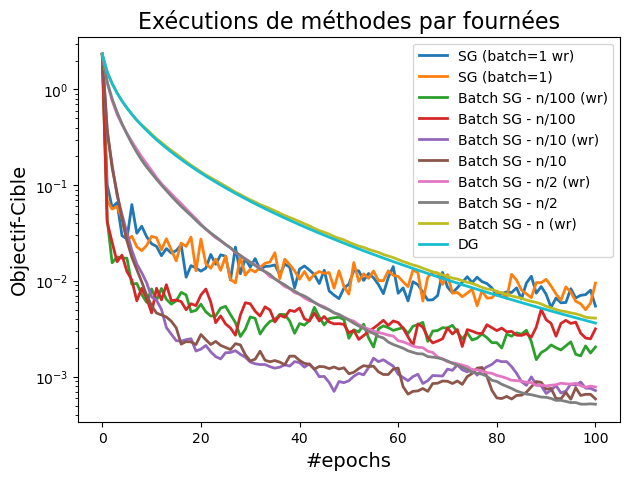

In [21]:
# Comparaison en termes de fonction objectif
plt.figure(figsize=(7, 5))
plt.semilogy(obj_ar-f_min_lin, label="SG (batch=1 wr)", lw=2)
plt.semilogy(obj_a-f_min_lin, label="SG (batch=1)", lw=2)
plt.semilogy(obj_br-f_min_lin, label="Batch SG - n/100 (wr)", lw=2)
plt.semilogy(obj_b-f_min_lin, label="Batch SG - n/100", lw=2)
plt.semilogy(obj_cr-f_min_lin, label="Batch SG - n/10 (wr)", lw=2)
plt.semilogy(obj_c-f_min_lin, label="Batch SG - n/10", lw=2)
plt.semilogy(obj_dr-f_min_lin, label="Batch SG - n/2 (wr)", lw=2)
plt.semilogy(obj_d-f_min_lin, label="Batch SG - n/2", lw=2)
plt.semilogy(obj_fr-f_min_lin, label="Batch SG - n (wr)", lw=2)
plt.semilogy(obj_f-f_min_lin, label="DG", lw=2)
plt.title("Exécutions de méthodes par fournées", fontsize=16)
plt.xlabel("#epochs", fontsize=14)
plt.ylabel("Objectif-Cible", fontsize=14)
plt.legend()

#### <span style="color:rgb(234,81,96)">Régimes des méthodes par fournées</span>

Sur ce problème (et cette exécution), on observe qu'il est possible d'obtenir une meilleure  convergence que le gradient stochastique de base en utilisant une fournée de taille supérieure à 1. Les courbes montrent qu'une taille de fournée de $n/100=10$ conduit à la fois à une convergence plus rapide et à une meilleur valeur finale de la fonction objectif (en dépit des oscillations). La taille de fournée $n/10=100$ conduit à une valeur d'objectif encore plus faible, mais la vitesse de convergence (pente observée sur les premières époques) est plus lente que sur les variantes déjà mentionnées. Enfin, la taille de fournée $n/2=500$ conduit à une courbe moins oscillante que les autres approches par fournées, mais la convergence est sensiblement ralentie.

Les différentes courbes illustrent bien les deux régimes mentionnés en cours : 
- Le régime *mini-fournée* correspond aux courbes orange et verte, qui obtiennent de meilleures valeurs d'objectif que le gradient stochastique (ainsi que la descente de gradient). Ces méthodes peuvent utiliser plus d'information qu'une stratégie basique (plus d'exemples du jeu de données) tout en pouvant faire beaucoup d'itérations par *époque*.
- La courbe rouge est typique du régime de *grande fournée*, dans lequel le comportement (et le coût) de la méthode est proche de celui de la descente de gradient.
- On voit que les variantes avec et sans remise sont semblables (de fait, celles pour $n_b=1$ sont deux réalisations du même procédé).

## <span style="color:rgb(234,81,96)">2.5 Réduction de variance et approches par fournées</span>

Dans cette dernière partie, on compare des méthodes de gradient stochastique par fournées sur plusieurs exécutions. Puisqu'une méthode de gradient stochastique est aléatoire, son comportement sur deux exécutions sera différent (car il dépend du tirage aléatoire des indices). On s'attend cependant à ce que l'effet de l'aléatoire soit moindre lorsque la taille de fournée est grande.

Le code ci-dessous compare plusieurs exécutions de méthodes de gradient stochastique par fournées.

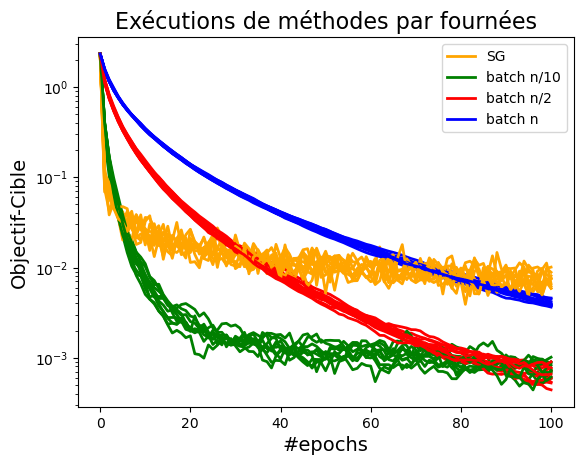

In [16]:
# Comparaison de 10 exécutions de gradient stochastique par fournées.

nb_epochs = 100
n = pblinreg.n
w0 = np.zeros(d)

nruns = 10

for i in range(nruns):
    # Gradient stochastique par fournées de taille 1 (=Gradient stochastique de base)
    _, obj_a, _ = stoch_grad(w0,pblinreg,w_min_lin,stepchoice=0.5,step0=0.2, n_iter=nb_epochs*n,nb=1,with_replace=True)
    # Gradient stochastique par fournées de taille n/10 (avec remise)
    nbset=int(n/10)
    _, obj_b, _ = stoch_grad(w0,pblinreg,w_min_lin,stepchoice=0.5,step0=0.2, n_iter=int(nb_epochs*n/nbset),nb=nbset,with_replace=True)
    # Gradient stochastique par fournées de taille n/2 (avec remise)
    nbset=int(n/2)
    _, obj_c, _ = stoch_grad(w0,pblinreg,w_min_lin,stepchoice=0.5,step0=0.2, n_iter=int(nb_epochs*n/nbset),nb=nbset,with_replace=True)
    # Gradient stochastique par fournées de taille n (avec remise)
    nbset=n
    _, obj_d, _ = stoch_grad(w0,pblinreg,w_min_lin,stepchoice=0.5,step0=0.2, n_iter=int(nb_epochs*n/nbset),nb=nbset,with_replace=True)
    
    
    if i<nruns-1:
        plt.semilogy(obj_a-f_min_lin,color='orange',lw=2)
        plt.semilogy(obj_b-f_min_lin,color='green', lw=2)
        plt.semilogy(obj_c-f_min_lin,color='red', lw=2)
        plt.semilogy(obj_d-f_min_lin,color='blue', lw=2)
plt.semilogy(obj_a-f_min_lin,label="SG",color='orange',lw=2)
plt.semilogy(obj_b-f_min_lin,label="batch n/10",color='green',lw=2)
plt.semilogy(obj_c-f_min_lin,label="batch n/2",color='red', lw=2)
plt.semilogy(obj_d-f_min_lin,label="batch n",color='blue', lw=2)    

plt.title("Exécutions de méthodes par fournées", fontsize=16)
plt.xlabel("#epochs", fontsize=14)
plt.ylabel("Objectif-Cible", fontsize=14)
plt.legend()

#### <span style="color:rgb(234,81,96)">Commentaires</span>

En plus de confirmer que les méthodes par fournées peuvent donner de meilleurs résultats que le gradient stochastique basique, la figure ci-dessus montre qu'augmenter la taille de fournée permet de diminuer les différences entre plusieurs exécutions du même algorithme. En ce sens, la figure confirme que l'utilisation d'une fournée est une technqiue de réduction de variance. 

On notera que la variante avec taille de fournée $n$ est aléatoire car le tirage est effectué avec remise. Cette méthode n'est donc pas équivalente à la descente de gradient, même si l'on voit qu'elle présente peu de variance.

# <span style="color:rgb(234,81,96)">Partie 3 - Variantes avancées du gradient stochastique</span>

On présente ici deux manières de modifier l'algorithme précédent pour obtenir des variantes utilisées notamment en apprentissage profond.

##  <span style="color:rgb(234,81,96)">3.1 Variantes avec normalisation</span>

#### <span style="color:rgb(234,81,96)">*RMSProp* et *Adagrad*</span>

*RMSProp* et *Adagrad* sont deux variantes qui normalisent un pas de gradient stochastique selon chaque coordonnée de la manière suivante :
 $$
     [\mathbf{w}_{k+1}]_i  = [\mathbf{w}_k]_i -\frac{\alpha}{\sqrt{[\mathbf{r}_k]_i + \epsilon}}[\nabla f_{i_k}(\mathbf{w}_k)]_i,
 $$ 
avec $\epsilon>0$ une valeur utilisée pour éviter les erreurs numériques de division par zéro et $\mathbf{r}_k \in \mathbb{R}^d$ définie de manière récursive par $\mathbf{r}_{-1} = 0_{\mathbb{R}^d}$ et
 $$ 
     \forall k \ge 0,\ \forall i=1,\dots,d, \qquad 
     [\mathbf{r}_k]_i = 
     \left\{
         \begin{array}{ll}
             \beta_2 [\mathbf{r}_{k-1}]_i + (1-\beta_2) [\nabla f_{i_k}(\mathbf{w}_k)]_i^2 &\mathrm{pour\ RMSProp,} \\
             [\mathbf{r}_{k-1}]_i + [\nabla f_{i_k}(\mathbf{w}_k)]_i^2 &\mathrm{pour\ Adagrad.}
         \end{array}
     \right.
 $$
(On pourra prendre $\epsilon=10^{-8}$ et $\beta_2=0.8$.)

On peut obtenir des variantes par fournées des deux méthodes en remplaçant $\nabla f_{i_k}(\mathbf{w}_k)$ par un estimé calculé à partir d'une fournée de gradients.

Le code ci-dessous implémente RMSProp et Adagrad, en utilisant un paramètre `scaling` valant $1$ pour Adagrad, $\beta_2$ pour RMSProp (et $0$ pour le gradient stochastique classique).

In [22]:
# Gradient stochastique avancé (avec normalisation)
def adv_stoch_grad(w0,problem,wtarget,stepchoice=0,step0=1, n_iter=1000,nb=1,scaling=0,with_replace=False,verbose=False): 
    """
        Code pour gradient stochastique, Adagrad et RMSProp
        
        Entrées:
            w0: Point initial
            problem: Instance à minimiser
                problem.fun(x) Fonction objectif
                problem.grad_i() Gradient d'une fonction f_i de la somme finie
                problem.lipgrad() Constante de Lipschitz pour le gradient
            wopt: Minimum cible pour l'optimisation
            stepchoice: Choix de taille de pas
                0: Constante proportionnelle à 1/L (L constante de Lipschitz pour le gradient)
                a>0: Décroissante, set to 1/((k+1)**a)
            step0: Taille de pas initiale
            n_iter: Maximum d'itérations
            nb: Taille de fournées
            scaling: Paramètre de normalisation
                0: Pas de normalisation (défaut)
                (0,1): Moyenne des amplitudes selon chaque coordonnée (RMSProp)
                1: Normalisation par les amplitudes selon chaque coordonnée (Adagrad)
            with_replace: Indicateur d'un tirage aléatoire des indices avec ou sans remise
            verbose: Affichage d'informations à chaque itération
            
        Sorties:
            w_output: Dernier itéré de la méthode
            objvals: Historique de valeurs de fonctions (tableau Numpy de taille n_iter+1)
            distits: Historique de distances à l'optimum cible (tableau Numpy de taille n_iter+1)
    """

    ############
    # Initialisation

    # Valeurs de fonction
    objvals = []
    
    # Distance au point cible
    normits = []
    
    # Lipschitz constant
    L = problem.lipgrad()
    
    # Nombre d'échantillons
    n = problem.n
    
    # Point initial
    w = w0.copy()
    nw = norm(w)
    
    # Normalisation
    if scaling>0:
        eps=10**(-8) # Evite les erreurs numériques
        v = np.zeros(d)

    # Compteur d'itérations
    k=0
    
    # Valeurs courantes
    obj = problem.fun(w) 
    objvals.append(obj);
    # 
    nmin = norm(w-wtarget)
    normits.append(nmin)
    
    # Affichage (optionnel)
    if verbose:
        print("Gradient stochastique, fournees de taille=",nb,"/",n)
        print(' | '.join([name.center(8) for name in ["iter", "fval", "normit"]]))
        print(' | '.join([("%d" % k).rjust(8),("%.2e" % obj).rjust(8),("%.2e" % nmin).rjust(8)]))
    
    ################
    # Boucle principale
    while (k < n_iter and nw < 10**100):
        
        #########################################
        # Tirer les indices
        ik = np.random.choice(n,nb,replace=with_replace)
        # Calculer les gradients stochastiques
        sg = np.zeros(d)
        for j in range(nb):
            gi = problem.grad_i(ik[j],w)
            sg = sg + gi
        sg = (1/nb)*sg
        ###########################################
        
        ###########################################
        # Normalisation
        if scaling>0:
            if scaling==1:
                # Adagrad
                v = v + sg*sg 
            else:
                # RMSProp
                v = scaling*v + (1-scaling)*sg*sg
            sg = sg/(np.sqrt(v+eps))
        ##########################################
            
        if stepchoice==0:
            w[:] = w - (step0/L) * sg
        elif stepchoice>0:
            sk = float(step0/((k+1)**stepchoice))
            w[:] = w - sk * sg
        
        nw = norm(w) #Calcul de norme pour éviter la divergence
        
        
        obj = problem.fun(w)
        nmin = norm(w-wtarget)
       
        
        k += 1
        # Affichage après chaque époque
        if (k*nb) % n == 0:
            objvals.append(obj)
            normits.append(nmin)
            if verbose:
                print(' | '.join([("%d" % k).rjust(8),("%.2e" % obj).rjust(8),("%.2e" % nmin).rjust(8)]))     
    
    # Fin boucle
    #################
    
    # Affichage
    if (k*nb) % n > 0:
        objvals.append(obj)
        normits.append(nmin)
        if verbose:
            print(' | '.join([("%d" % k).rjust(8),("%.2e" % obj).rjust(8),("%.2e" % nmin).rjust(8)]))              
    
    # Itéré final
    w_output = w.copy()
    
    return w_output, np.array(objvals), np.array(normits)

Le script ci-dessous pour comparer RMSProp et Adagrad (avec tailles de pas constante et décroissante) avec une méthode de gradient stochastique classique (utilisant une taille de pas décroissante). 

In [23]:
# Comparaison de méthodes avec taille de fournée égale à 1

nb_epochs = 60
n = pblinreg.n
w0 = np.zeros(d)

# Gradient stochastique classique (taille de pas décroissante)
w_a, obj_a, nits_a = adv_stoch_grad(w0,pblinreg,w_min_lin,stepchoice=0.5,step0=0.2, n_iter=nb_epochs*n,nb=1)
# Adagrad (taille de pas décroissante)
w_bd, obj_bd, nits_bd = adv_stoch_grad(w0,pblinreg,w_min_lin,stepchoice=0.5,step0=0.2, n_iter=nb_epochs*n,nb=1,scaling=1)
# RMSProp (taille de pas décroissante)
w_cd, obj_cd, nits_cd = adv_stoch_grad(w0,pblinreg,w_min_lin,stepchoice=0.5,step0=0.2, n_iter=nb_epochs*n,nb=1,scaling=0.8)
# Adagrad (taille de pas constante)
w_bc, obj_bc, nits_bc = adv_stoch_grad(w0,pblinreg,w_min_lin,stepchoice=0,step0=0.2, n_iter=nb_epochs*n,nb=1,scaling=1)
# RMSProp (taille de pas constante)
w_cc, obj_cc, nits_cc = adv_stoch_grad(w0,pblinreg,w_min_lin,stepchoice=0,step0=0.2, n_iter=nb_epochs*n,nb=1,scaling=0.8)


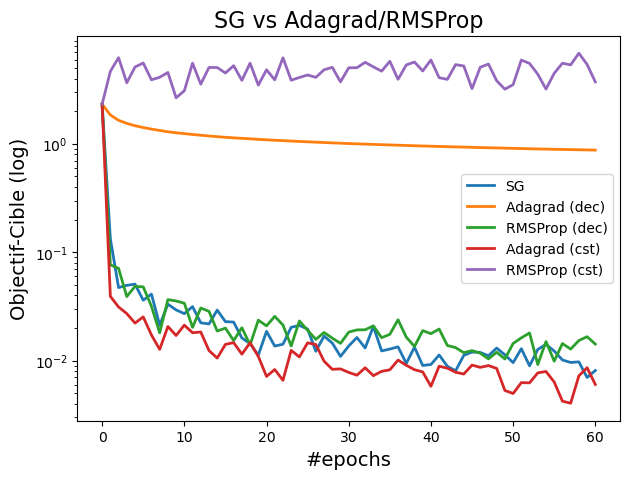

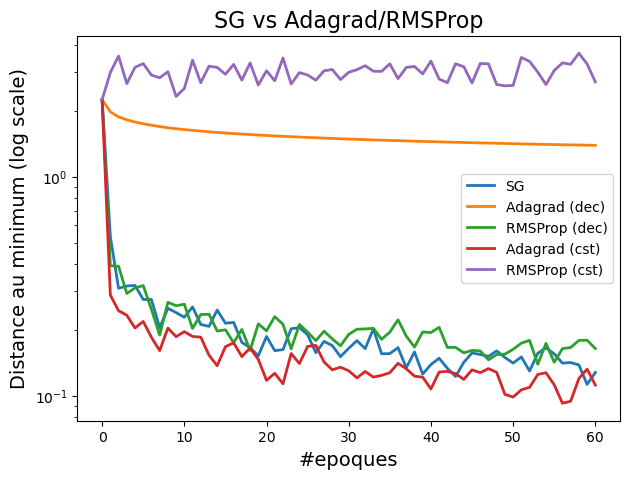

In [24]:
# Affichage des résultats
# En termes d'écart à la valeur optimale numérique
plt.figure(figsize=(7, 5))
plt.semilogy(obj_a-f_min_lin, label="SG", lw=2)
plt.semilogy(obj_bd-f_min_lin, label="Adagrad (dec)", lw=2)
plt.semilogy(obj_cd-f_min_lin, label="RMSProp (dec)", lw=2)
plt.semilogy(obj_bc-f_min_lin, label="Adagrad (cst)", lw=2)
plt.semilogy(obj_cc-f_min_lin, label="RMSProp (cst)", lw=2)
plt.title("SG vs Adagrad/RMSProp", fontsize=16)
plt.xlabel("#epochs", fontsize=14)
plt.ylabel("Objectif-Cible (log)", fontsize=14)
plt.legend()
# En termes de distance au minimum numérique
plt.figure(figsize=(7, 5))
plt.semilogy(nits_a, label="SG", lw=2)
plt.semilogy(nits_bd, label="Adagrad (dec)", lw=2)
plt.semilogy(nits_cd, label="RMSProp (dec)", lw=2)
plt.semilogy(nits_bc, label="Adagrad (cst)", lw=2)
plt.semilogy(nits_cc, label="RMSProp (cst)", lw=2)
plt.title("SG vs Adagrad/RMSProp", fontsize=16)
plt.xlabel("#epoques", fontsize=14)
plt.ylabel("Distance au minimum (log scale)", fontsize=14)
plt.legend()

#### <span style="color:rgb(234,81,96)">Commentaires</span>

Comme Adagrad et RMSProp accumulent de l'information des composantes de gradient stochastique au fur et à mesure des itérations, les tailles de pas pour chaque coordonnée tendent vers $0$. Si la taille de pas globale décroît trop rapidement, cela peut conduire à des pas trop faibles, comme pour Adagrad avec une taille de pas décroissante. 

Dans le même temps, pour des tailles de pas constantes, Adagrad peut être meilleur que le gradient stochastique classique. La performance de RMSProp (connue pour être bonne sur les réseaux très profonds) est quant à elle très dépendante du choix de $\beta_2$/`scaling` (ainsi que de celui de la taille de pas constante).

## <span style="color:rgb(234,81,96)">3.2 Gradient stochastique et momentum</span>

#### <span style="color:rgb(234,81,96)">*Gradient stochastique avec momentum* et *Adam*</span>

Certaines variantes du gradient stochastique utilisent le momentum en combinant des pas de gradient stochastique classique avec des pas des itérations précédentes.

*Le gradient stochastique avec momentum* utilise l'itération précédente de la manière suivante :
$$
    \mathbf{w}_{k+1} = \mathbf{w}_k - \alpha_k \mathbf{m}_k, 
    \quad \mathrm{where} \quad
    \mathbf{m}_k = \beta_1 \mathbf{m}_{k-1} + (1-\beta_1)\nabla f_{i_k}(\mathbf{w}_k)
$$
avec $\beta_1 \in (0,1)$ (si $\beta_1=0$, on retombe sur le gradient stochastique standard).

*Adam* combine l'idée du momentum avec la normalisation. Dans les deux cas, l'information des itérations précédentes est utilisée. Une manière d'écrire l'itération d'Adam est 
$$
    \mathbf{w}_{k+1} = \mathbf{w}_k - \alpha_k \mathbf{m}_k \oslash \sqrt{\mathbf{v}_k},
$$
avec
$$
    \mathbf{m}_k = \frac{1-\beta_1^k}{1-\beta_1^{k+1}}\beta_1\mathbf{m}_{k-1} + \frac{1-\beta_1}{1-\beta_1^{k+1}}\nabla f_{i_k}(\mathbf{w}_k)
$$
et
$$
    \mathbf{v}_k = \frac{1-\beta_2^k}{1-\beta_2^{k+1}}\beta_2\mathbf{v}_{k-1} + \frac{1-\beta_2}{1-\beta_2^{k+1}}\nabla f_{i_k}(\mathbf{w}_k)\otimes\nabla f_{i_k}(\mathbf{w}_k).
$$

En pratique, comme pour les méthodes de la section précédente, on remplacera $\mathbf{v}_k$ 
par $\mathbf{v}_k+\epsilon$.

Le code ci-dessous compare les méthodes avec et sans momentum. 

In [25]:
# Gradient stochastique avec momentum
def stoch_grad_momentum(w0,problem,wtarget,stepchoice=0,step0=1, n_iter=1000,nb=1,beta1=0.9,beta2=0.999,with_replace=False,verbose=False): 
    """
        Un code pour le gradient stochastique standard, avec momentum, et Adam
        
        Entrées:
            w0: Point initial
            problem: Instance à minimiser
                problem.fun(x) Fonction objectif
                problem.grad_i() Gradient d'une fonction f_i de la somme finie
                problem.lipgrad() Constante de Lipschitz pour le gradient
            wopt: Minimum cible pour l'optimisation
            stepchoice: Choix de taille de pas
                0: Constante proportionnelle à 1/L (L constante de Lipschitz pour le gradient)
                a>0: Décroissante, set to 1/((k+1)**a)
            step0: Taille de pas initiale
            n_iter: Maximum d'itérations
            nb: Taille de fournées
            beta1: Paramètre de momentum
                0: Gradient stochastique classique
                (0,1): Méthode avec momentum (défaut: 0.9)
            beta2: Paramètre de normalisation
                0: Pas de normalisation (Gradient stochastique avec/sans momentum)
                (0,1): Paramètre de moyenne (Adam, défaut: 0.999) 
            with_replace: Indicateur d'un tirage aléatoire des indices avec ou sans remise
            verbose: Affichage d'informations à chaque itération
            
        Sorties:
            w_output: Dernier itéré de la méthode
            objvals: Historique de valeurs de fonctions (tableau Numpy de taille n_iter+1)
            distits: Historique de distances à l'optimum cible (tableau Numpy de taille n_iter+1)
    """

    ############
    # Initialisation

    # Historique des fonctions objectifs et distance au point cible
    objvals = []
    normits = []
    
    # Constante de Lipschitz
    L = problem.lipgrad()
    
    # Nombre d'échantillons
    n = problem.n
    
    # Valeur du point initial  
    w = w0.copy()
    nw = norm(w)
    
    # Vecteur de déplacement
    mv = np.zeros(d)
    
    # Valeur de normalisation
    if beta2>0:
        eps=10**(-8) # Pour éviter les erreurs numériques
        v = np.zeros(d)

    # Compteur d'itérations
    k=0
    
    # Valeurs courantes
    obj = problem.fun(w) 
    objvals.append(obj);
    # 
    nmin = norm(w-wtarget)
    normits.append(nmin)
    
    # Affichage (optionnel)
    if verbose:
        print("Gradient stochastique, fournées=",nb,"/",n)
        print(' | '.join([name.center(8) for name in ["iter", "fval", "normit"]]))
        print(' | '.join([("%d" % k).rjust(8),("%.2e" % obj).rjust(8),("%.2e" % nmin).rjust(8)]))
    
    ################
    # Boucle principale
    while (k < n_iter and nw < 10**100):
        
        #########################################
        # COMPLETER AVEC L'IMPLEMENTATION DE LA QUESTION 1
        # Tirer les indices
        ik = np.random.choice(n,nb,replace=with_replace)
        # Calculer les gradients stochastiques
        sg = np.zeros(d)
        for j in range(nb):
            gi = problem.grad_i(ik[j],w)
            sg = sg + gi
        sg = (1/nb)*sg
        ###########################################
        
        ###########################################
        # MISE A JOUR DE MV
        if beta1>0:
            if beta2>0:
                mv = ((1-beta1**k)/(1-beta1**(k+1)))*beta1*mv + ((1-beta1)/(1-beta1**(k+1)))*sg
            else:
                mv = beta1*mv + (1-beta1)*sg
        else:
            mv = sg
            
        ###########################################
        # MISE A JOUR DE V 
        if beta2>0:
            v = ((1-beta2**k)/(1-beta2**(k+1)))*beta2*v + ((1-beta2)/(1-beta2**(k+1)))*sg*sg
            mv = mv/(np.sqrt(v+eps))
        ##########################################
            
        if stepchoice==0:
            w[:] = w - (step0/L) * mv
        elif stepchoice>0:
            sk = float(step0/((k+1)**stepchoice))
            w[:] = w - sk * mv
        
        nw = norm(w) #Calcul de norm qui évite de diverger
        
        obj = problem.fun(w)
        nmin = norm(w-wtarget)
        
        k += 1
        # Affichage
        if (k*nb) % n == 0:
            objvals.append(obj)
            normits.append(nmin)
            if verbose:
                print(' | '.join([("%d" % k).rjust(8),("%.2e" % obj).rjust(8),("%.2e" % nmin).rjust(8)]))     
    
    # Fin boucle principale
    #################
    
    # Affichage
    if (k*nb) % n > 0:
        objvals.append(obj)
        normits.append(nmin)
        if verbose:
            print(' | '.join([("%d" % k).rjust(8),("%.2e" % obj).rjust(8),("%.2e" % nmin).rjust(8)]))              
    
    # Dernier itéré
    w_output = w.copy()
    
    return w_output, np.array(objvals), np.array(normits)

In [26]:
# Comparaison numérique
nb_epochs = 100
n = pblinreg.n
w0 = np.zeros(d)

# Gradient stochastique classique (taille de pas décroissante)
x_sg, obj_sg, nits_sg = stoch_grad_momentum(w0,pblinreg,w_min_lin,stepchoice=0.5,step0=0.2, n_iter=nb_epochs*n,nb=1,beta1=0,beta2=0)
# Gradient stochastique avec momentum (taille de pas décroissante)
x_sgm_d, obj_sgm_d, nits_sgm_d = stoch_grad_momentum(w0,pblinreg,w_min_lin,stepchoice=0.5,step0=0.2, n_iter=nb_epochs*n,nb=1,beta1=0.9,beta2=0)
# Adam (taille de pas décroissante)
x_adam_d, obj_adam_d, nits_adam_d = stoch_grad_momentum(w0,pblinreg,w_min_lin,stepchoice=0.5,step0=0.2, n_iter=nb_epochs*n,nb=1)
# Gradient stochastique avec momentum (taille de pas constante)
x_sgm_c, obj_sgm_c, nits_sgm_c = stoch_grad_momentum(w0,pblinreg,w_min_lin,stepchoice=0,step0=0.001, n_iter=nb_epochs*n,nb=1,beta1=0.9,beta2=0)
# Adam (taille de pas constante)
x_adam_c, obj_adam_c, nits_adam_c = stoch_grad_momentum(w0,pblinreg,w_min_lin,stepchoice=0,step0=0.2, n_iter=nb_epochs*n,nb=1)

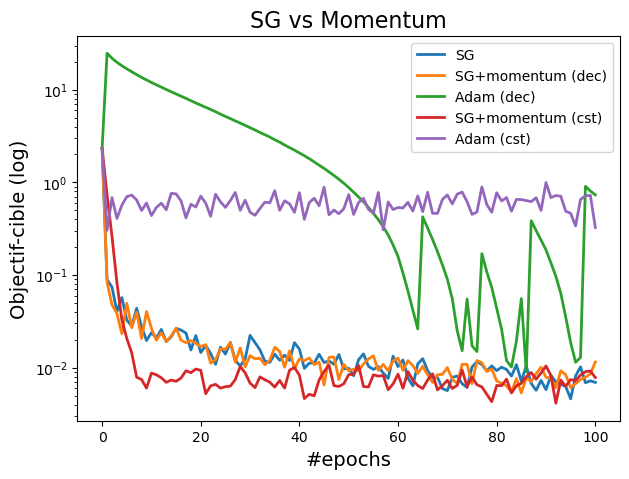

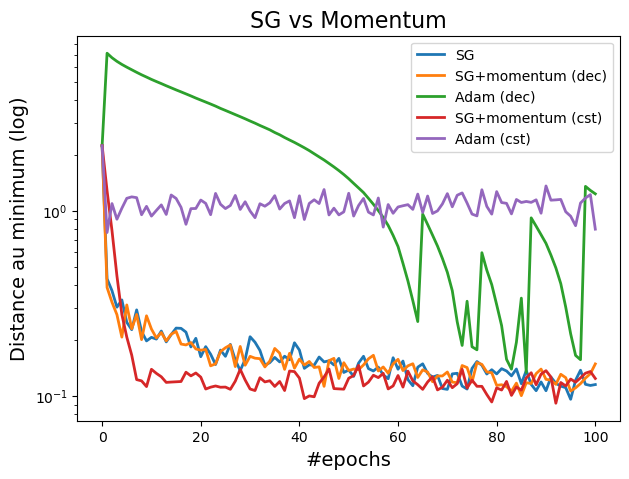

In [27]:
# Résultats
# En termes de valeurs de fonctions
plt.figure(figsize=(7, 5))
plt.semilogy(obj_sg-f_min_lin, label="SG", lw=2)
plt.semilogy(obj_sgm_d-f_min_lin, label="SG+momentum (dec)", lw=2)
plt.semilogy(obj_adam_d-f_min_lin, label="Adam (dec)", lw=2)
plt.semilogy(obj_sgm_c-f_min_lin, label="SG+momentum (cst)", lw=2)
plt.semilogy(obj_adam_c-f_min_lin, label="Adam (cst)", lw=2)
plt.title("SG vs Momentum", fontsize=16)
plt.xlabel("#epochs", fontsize=14)
plt.ylabel("Objectif-cible (log)", fontsize=14)
plt.legend()
# En termes de distance au minimum cible
plt.figure(figsize=(7, 5))
plt.semilogy(nits_sg, label="SG", lw=2)
plt.semilogy(nits_sgm_d, label="SG+momentum (dec)", lw=2)
plt.semilogy(nits_adam_d, label="Adam (dec)", lw=2)
plt.semilogy(nits_sgm_c, label="SG+momentum (cst)", lw=2)
plt.semilogy(nits_adam_c, label="Adam (cst)", lw=2)
plt.title("SG vs Momentum", fontsize=16)
plt.xlabel("#epochs", fontsize=14)
plt.ylabel("Distance au minimum (log)", fontsize=14)
plt.legend()

#### <span style="color:rgb(234,81,96)">Commentaires</span> 

La méthode de gradient stochastique est aussi performante voire meilleure que le gradient stochastique sur ce problème (qui est fortement convexe et quadratique). La performance d'Adam est plus variable, notamment avec les paramètres par défaut (cette méthode est très prisée pour entraîner les réseaux de neurones, ce qui ne correspond pas à notre cadre). En jouant avec $\beta_1$, $\beta_2$ et la taille de pas, on peut chercher à améliorer la performance de cette méthode.

In [16]:
# Version 4.9 - C. W. Royer, janvier 2026.